# Impact of News Sentiment on Stocks
### 1. News Sentiment Analysis
### 2. Stock Analysis

## 1. News Sentiment Analysis

In [21]:
# !pip install seaborn

In [22]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
# nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import yfinance as yf

In [3]:
# params
n=3 # number of headlines displayed per ticker
tickers=['AAPL','MSFT','AMZN']

In [4]:
# Get Data
finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

In [5]:
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [6]:
try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for AAPL: 
Dow Jones Futures: Stimulus Deal Vote Due After Stock Market Rally Off Lows, Tesla Sinks In S&P 500 Debut; Apple, Peloton Rise Late ( Dec-21-20 06:32PM )
Dow Jones Stocks To Buy And Watch In December 2020: Apple Reverses ( 06:12PM )
Apple (AAPL) Gains As Market Dips: What You Should Know ( 05:45PM )


Recent News Headlines for MSFT: 
Google, Cisco and VMware join Microsoft to oppose NSO Group in WhatsApp spyware case ( Dec-21-20 06:23PM )
Microsoft, Google, Cisco, VMware join legal battle against hacking company NSO ( 05:29PM )
Electronic Arts Makes a Move ( 05:29PM )


Recent News Headlines for AMZN: 
Electronic Arts Makes a Move ( Dec-21-20 05:29PM )
3 Stocks You Didn't Know Were Betting on Renewable Energy ( 05:00PM )
Googles Aramco Deal Risks Irking Staff Over Oil, Politics ( 04:28PM )


In [7]:
# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

In [8]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [9]:
news.head()

,Ticker,Date,Time,Headline,neg,neu,pos,compound
0,AAPL,Dec-21-20,06:32PM,Dow Jones Futures: Stimulus Deal Vote Due Afte...,0.076,0.924,0.000,-0.2023
1,AAPL,Dec-21-20,06:12PM,Dow Jones Stocks To Buy And Watch In December ...,0.000,1.000,0.000,0.0000
2,AAPL,Dec-21-20,05:45PM,Apple (AAPL) Gains As Market Dips: What You Sh...,0.000,0.789,0.211,0.3400
3,AAPL,Dec-21-20,05:43PM,Apple Targets Autonomous Car for Consumers by ...,0.000,1.000,0.000,0.0000
4,AAPL,Dec-21-20,05:43PM,Apple reportedly plans production of electric ...,0.000,1.000,0.000,0.0000


In [10]:
news.to_csv('hl_12_21.csv')

In [11]:
# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}


In [12]:
values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)



              Date     Time    neg    neu    pos  compound
Ticker                                                    
AAPL    2020-12-21  06:32PM  0.076  0.924  0.000   -0.2023
AAPL    2020-12-21  06:12PM  0.000  1.000  0.000    0.0000
AAPL    2020-12-21  05:45PM  0.000  0.789  0.211    0.3400
AAPL    2020-12-21  05:43PM  0.000  1.000  0.000    0.0000
AAPL    2020-12-21  05:43PM  0.000  1.000  0.000    0.0000


              Date     Time    neg    neu    pos  compound
Ticker                                                    
MSFT    2020-12-21  06:23PM  0.000  0.855  0.145    0.2960
MSFT    2020-12-21  05:29PM  0.182  0.559  0.259    0.0258
MSFT    2020-12-21  05:29PM  0.000  1.000  0.000    0.0000
MSFT    2020-12-21  05:05PM  0.000  1.000  0.000    0.0000
MSFT    2020-12-21  04:36PM  0.274  0.726  0.000   -0.3400


              Date     Time    neg    neu    pos  compound
Ticker                                                    
AMZN    2020-12-21  05:29PM  0.000  1.000  0.000  

In [13]:
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



        Mean Sentiment
Ticker                
AMZN              0.17
MSFT              0.03
AAPL              0.02


In [14]:
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

print('ok!')

ok!


## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>Now that we have the data and the algorithm loaded, we will get to the core of the matter: programmatically predicting sentiment out of news headlines! Luckily for us, VADER is very high level so, in this case, we will not adjust the model further<sup>*</sup> other than the lexicon additions from before.</p>
<p><sup>*</sup>VADER "out-of-the-box" with some extra lexicon would likely translate into <strong>heavy losses</strong> with real money. A real sentiment analysis tool with chances of being profitable will require a very extensive and dedicated to finance news lexicon. Furthermore, it might also not be enough using a pre-packaged model like VADER.</p>

In [15]:
news

,Ticker,Date,Time,Headline,neg,neu,pos,compound
0,AAPL,2020-12-21,06:32PM,Dow Jones Futures: Stimulus Deal Vote Due Afte...,0.076,0.924,0.000,-0.2023
1,AAPL,2020-12-21,06:12PM,Dow Jones Stocks To Buy And Watch In December ...,0.000,1.000,0.000,0.0000
2,AAPL,2020-12-21,05:45PM,Apple (AAPL) Gains As Market Dips: What You Sh...,0.000,0.789,0.211,0.3400
3,AAPL,2020-12-21,05:43PM,Apple Targets Autonomous Car for Consumers by ...,0.000,1.000,0.000,0.0000
4,AAPL,2020-12-21,05:43PM,Apple reportedly plans production of electric ...,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
295,AMZN,2020-12-17,11:58AM,AMZN Stock: Consider A Bull Put Spread For Thi...,0.000,1.000,0.000,0.0000
296,AMZN,2020-12-17,11:38AM,Amazon Has a New Strategy to Capture India's E...,0.000,0.825,0.175,0.1779
297,AMZN,2020-12-17,11:30AM,3 Top Tech Stocks to Buy During a Recession,0.292,0.521,0.188,-0.2500
298,AMZN,2020-12-17,10:47AM,Why Roku Stock Jumped Today,0.000,1.000,0.000,0.0000


<AxesSubplot:xlabel='Date'>

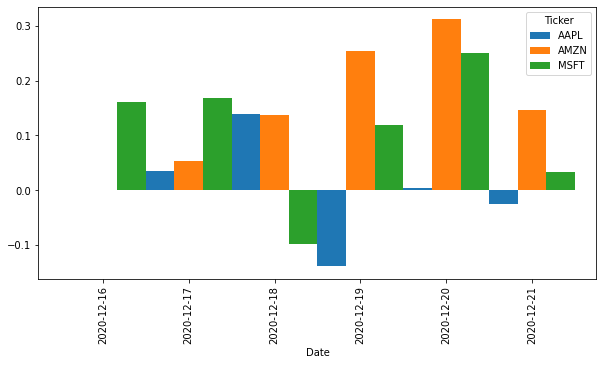

In [16]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = news.groupby(['Date', 'Ticker']).mean()

# Unstack the column ticker
mean_c = mean_c.unstack('Ticker')

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')
# Plot a bar chart with pandas

mean_c.plot(kind='bar', figsize=(10,5), width=1)

## 7. Weekends and duplicates
<p>What happened to Tesla on November 22nd? Since we happen to have the headlines inside our <code>DataFrame</code>, a quick peek reveals that there are a few problems with that particular day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>Let's clean up the dataset a bit, but not too much! While some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. What we want to get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around, so to speak.</p>

## 7. Weekends and duplicates
<p>What happened to AMZN on Dec 21st? Since we happen to have the headlines inside our <code>DataFrame</code>, a quick peek reveals that there are a few problems with that particular day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>Let's clean up the dataset a bit, but not too much! While some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. What we want to get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around, so to speak.</p>

In [17]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = news['Headline'].count()

# Drop duplicates based on ticker and headline
scored_news_clean = news.drop_duplicates(subset=['Ticker','Headline'])
                      
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['Headline'].count()
                                                        
# Print before and after numbers to get an idea of how we did 
print(f"Before we had {num_news_before} headlines, now we have {num_news_after}")

Before we had 300 headlines, now we have 299


## Sentiment on one single trading day and stock

In [18]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['Ticker', 'Date'])
# Cross-section the fb row
single_day = single_day.xs('AMZN')

# Select the 3rd of January of 2019
single_day = single_day['2020-12-21']

# Convert the datetime string to just the time
single_day['Time'] = pd.to_datetime(single_day['Time']).dt.time

# Set the index to time and 
single_day = single_day.set_index('Time')

# Sort it
single_day = single_day.sort_index()
print(single_day.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 00:28:00 to 17:29:00
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Headline  30 non-null     object 
 1   neg       30 non-null     float64
 2   neu       30 non-null     float64
 3   pos       30 non-null     float64
 4   compound  30 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.4+ KB
None


<AxesSubplot:title={'center':'Positive, negative and neutral sentiment for AMZN on 2020-12-21'}, xlabel='Time'>

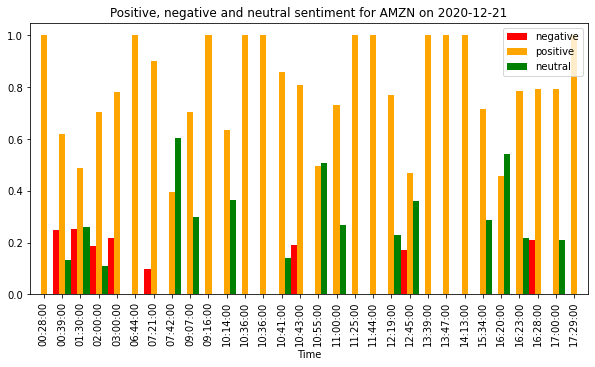

In [19]:
TITLE = "Positive, negative and neutral sentiment for AMZN on 2020-12-21"
COLORS = ["red", "orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['Headline', 'compound'], axis=1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']

# Plot a stacked bar chart
plot_day.plot(kind='bar', title=TITLE, color=COLORS, figsize=(10,5), width=1)


## 2. Stock Analysis

In [21]:
# !pip install yfinance --upgrade --no-cache-dir

Taking only AMZN for the moment

## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>Now that we have the data and the algorithm loaded, we will get to the core of the matter: programmatically predicting sentiment out of news headlines! Luckily for us, VADER is very high level so, in this case, we will not adjust the model further<sup>*</sup> other than the lexicon additions from before.</p>
<p><sup>*</sup>VADER "out-of-the-box" with some extra lexicon would likely translate into <strong>heavy losses</strong> with real money. A real sentiment analysis tool with chances of being profitable will require a very extensive and dedicated to finance news lexicon. Furthermore, it might also not be enough using a pre-packaged model like VADER.</p>